# Supplement A
# Microwave Radiometer Temperature and Humidity Retrieval

In the following, we introduce the use of the pyOptimalEstimation Python library using a standard temperature
and humidity retrieval for a microwave radiometer (MWR, Rose et al 2005). We use the simple forward operator
introduced by Löhnert et al. (2004) which does not account for scattering by hydrometeors. The prior is
estimated based on 16 years of spring (March - May) radiosonde observations at the U.S. Department of Energy
Atmospheric Radiation Measurement (ARM) program at the North Slope of Alaska (NSA) site in Utqiagvik (Barrow),
Alaska. See the `prepare_radiosondes.ipynb` script in `lib` for details.

# Preparation
**You can skip the installation if you execute this online on binder**

In order to design a retrieval with pyOptimalEstimation, we need to install the library first with
~~~~
pip install pyOptimalEstimation
~~~~
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib
libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray
libraries. For development, we used Numpy 1.18.1, Matplotlib 3.0.3, Scipy 1.2.1, Xarray 0.15.1, Pandas 1.0.3, Seaborn 0.9.0 and Uncertainties 3.0.3.

Before we start, we need to load all required Python libraries

In [3]:
import sys
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr
import scipy.stats as stats

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')

We put some helper routines and the radiative transfer model in the `lib` folder which we load with 

In [4]:
sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

# Load prior dataset
We start with loading the the previously prepared (see [lib/prepare_radiosondes.ipynb](lib/prepare_radiosondes.ipynb)) collection of radiosonde profiles at NSA from 04/2002 to 02/2020. We use the xarray library which provides a transparent interface to netCDF files so that we can directly copy the required variables form the netCDF file. The unit of temperature is Kelvin, specific humidity is provided in g/kg, and pressure is in Pa.


In [5]:
prior = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')
prior

<xarray.Dataset>
Dimensions:   (height: 60, time: 24095)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29 ... 2020-02-04T18:00:00
  * height    (height) float32 8.0 108.0 208.0 ... 1.901e+04 2.001e+04 2.251e+04
Data variables:
    temp      (time, height) float32 ...
    q         (time, height) float32 ...
    bar_pres  (time, height) float32 ...

Optimal Estimation requires that the distribution of the prior data is following a normal distribution. We use Quantile-quantile (QQ) plots to evaluate whether this condition is fulfilled for temperature and humidity using both linear (left) and logarithmic (right). Normal distributions are located on the red line and have a higher $R^2$ value

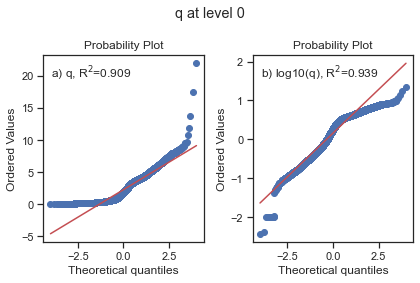

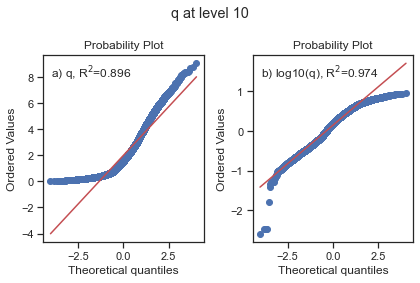

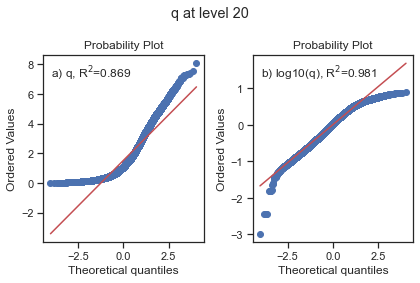

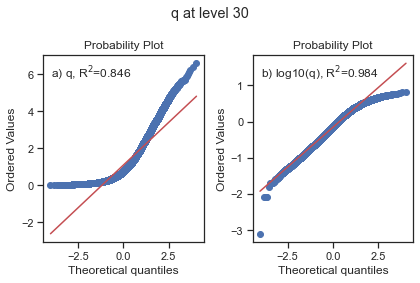

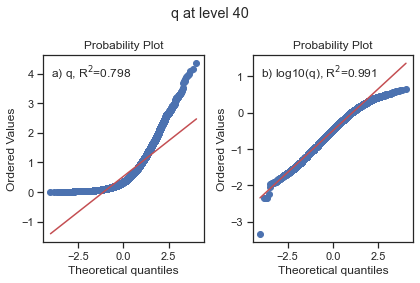

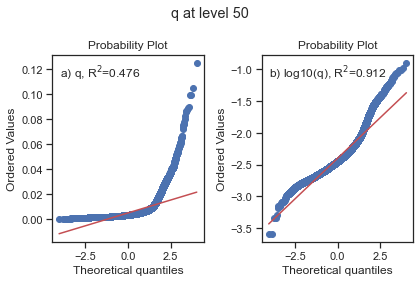

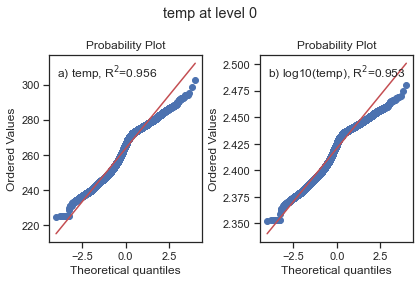

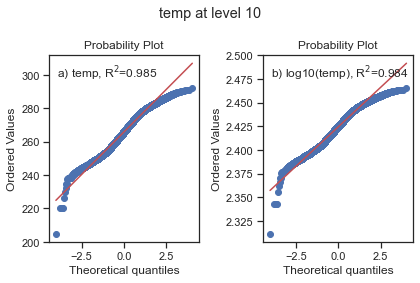

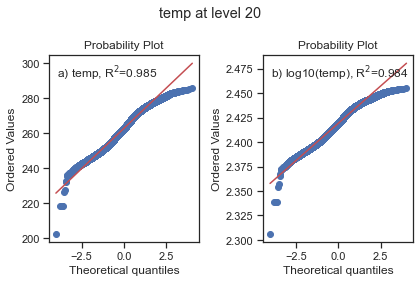

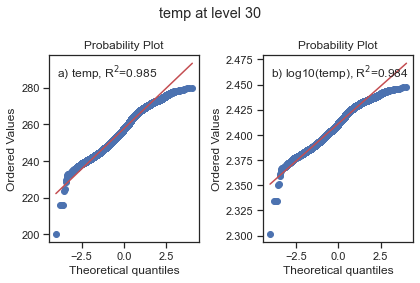

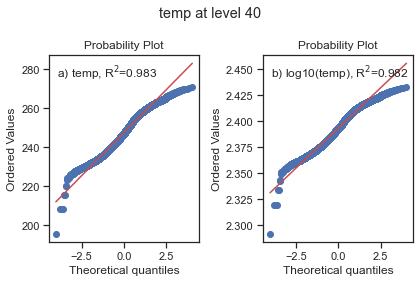

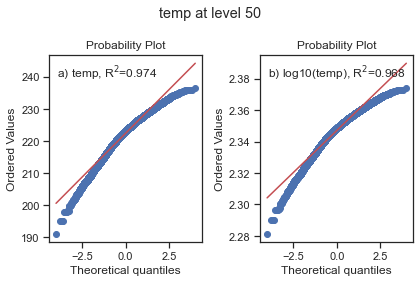

In [6]:
for var in ['q', 'temp']:
    for h in range(0, 60, 10):
        fig, (ax, ax1) = plt.subplots(ncols=2)
        plt.suptitle('%s at level %i' % (var,h))
        (osm, osr), (slope, intercept, r) = stats.probplot(
            prior[var].isel(height=h).dropna('time').values,
            dist="norm",
            plot=ax,
            fit=True,
            rvalue=False)
        ax.text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % ('a', var, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            np.log10(prior[var].isel(height=h).dropna('time').values),
            dist="norm",
            plot=ax1,
            fit=True,
            rvalue=False)
        ax1.text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % ('b', 'log10(%s)'%var, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax1.transAxes)
        fig.tight_layout()

For humidity, it can be seen that the distribution is more normal when using logarithmic units. Using logarithmic units makes also sure that the retrieval cannot converge to non-physical negative values. For temperature, instead, there is no benefit in using a logarithmic distribution and we stick with using temperature in linear units.

In [7]:
prior['q'] = np.log10(prior['q'])

We select sample profiles and remove them from the prior data. We will use them to
estimate synthetic observations. By this, we can evaluate the retrieval result by comparison with the true
atmospheric state and we are not impacted by potential forward operator biases.

In [8]:
profileTT = np.array([
    '2004-03-16T12:00:00.000000000', '2006-04-01T00:00:00.000000000',
    '2009-01-30T18:00:00.000000000', '2014-07-27T06:00:00.000000000',
    '2018-01-08T12:00:00.000000000'
],dtype='datetime64[ns]')

profiles = prior.sel(time=profileTT)
prior = prior.drop_sel(time=profileTT)
nLev = len(prior.height)

We want to estimate the prior for all four seasons separately, so we split the data set up by season

In [9]:
priors = {'all': prior}

seasons = [
    'DJF',
    'MAM',
    'JJA',
    'SON',
]
months = (
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11],
)
for season, month in zip(seasons, months):
    priors[season] = prior.where(
        np.in1d(prior['time.month'], month)[:, np.newaxis]).dropna(
            'time', how='all')

In preparation for estimating the covariance matrix, we create a pandas DataFrame of dimension _time x state-variable_. pandas (`pn`) `Series` and `DataFrame` objects  are basically annotated arrays. This makes keeping track of the various elements of $\mathbf{x}$ and $\mathbf{y}$ easier.

We need names for our $\mathbf{x}$ variables to avoid any confusion. Therefore, we use a string containing the height in meters and the variable name (t or q). E.g., '00008_q' is humidity at 8 m altitude.

In [10]:
prior_qts = {}
for season in priors.keys():
    prior_q = priors[season]['q'].to_pandas()
    prior_q.columns = ['%05i_q' % (i) for i in prior_q.columns]
    prior_t = priors[season]['temp'].to_pandas()
    prior_t.columns = ['%05i_t' % (i) for i in prior_t.columns]
    prior_qts[season] = pn.concat((prior_q, prior_t), axis=1)
    prior_qts[season] = prior_qts[season].reindex(
        sorted(prior_qts[season].columns), axis=1)

prior_qts

{'all':                       00008_q     00008_t   00107_q     00107_t   00207_q  \
 time                                                                        
 2002-04-29 00:00:00  0.064744  261.699982  0.120490  262.639984  0.121120   
 2002-04-29 06:00:00  0.026484  260.470001  0.111891  261.729980  0.115678   
 2002-04-29 12:00:00 -0.012288  259.239990  0.032706  259.380005  0.046552   
 2002-04-29 18:00:00 -0.051580  258.009979 -0.048208  257.019989 -0.023759   
 2002-04-30 00:00:00  0.058703  261.549988 -0.023267  260.049988 -0.026649   
 ...                       ...         ...       ...         ...       ...   
 2020-02-03 18:00:00 -0.976898  235.709991 -0.543270  243.750000 -0.534117   
 2020-02-04 00:00:00 -0.950991  236.199997 -0.545425  244.479996 -0.501717   
 2020-02-04 06:00:00 -1.003483  235.179993 -0.464527  245.580002 -0.454255   
 2020-02-04 12:00:00 -0.714312  241.269989 -0.544978  244.059998 -0.492173   
 2020-02-04 18:00:00 -0.819013  238.909988 -0.580955  242

Now, we can estimate the mean $\mathbf{x}_{a}$ and covariance **S**$_a$ of the prior easily and combine them for all seasons:

In [11]:
x_cov = []
x_mean = []

for season in ['all'] + seasons:

    x_cov1 = prior_qts[season].cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
    x_mean1 = prior_qts[season].mean().rename_axis('state', axis=0)

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))

x_cov = xr.concat(x_cov, dim='season')
x_mean = xr.concat(x_mean, dim='season')

x_cov['season'] = ['all'] + seasons
x_mean['season'] = ['all'] + seasons

It is crucial that the covariance matrix can be inverted (i.e. is not singular) which we test with calculating the rank

In [12]:
for season in x_cov.season:
    assert np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()) ==  x_cov.shape[-1]

The resulting mean profiles are plotted for every season

Text(0, 0.5, 'Height [m]')

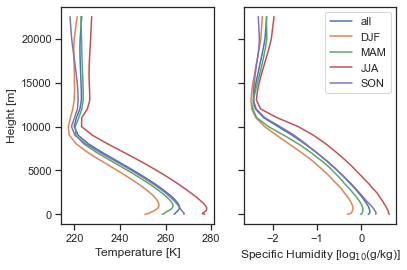

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
for season in ['all'] + seasons:
    t, q = supporting_routines.splitTQ(x_mean.sel(season=season).to_pandas())
    ax1.plot(t, t.index, label=season)
    ax2.plot(q, q.index, label=season)

ax2.legend()
ax1.set_xlabel('Temperature [K]')
ax2.set_xlabel('Specific Humidity [log$_{10}$(g/kg)]')
ax1.set_ylabel('Height [m]')

We plot the spring covariance matrix. Note how the Tropopause can be clearly seen around 10 km. For convenience, we show the covariance matrix separately for T and q even though we consider correlations between T and q. 

Text(0.5, 1.0, '$\\mathbb{S}_{a}$ Humidity')

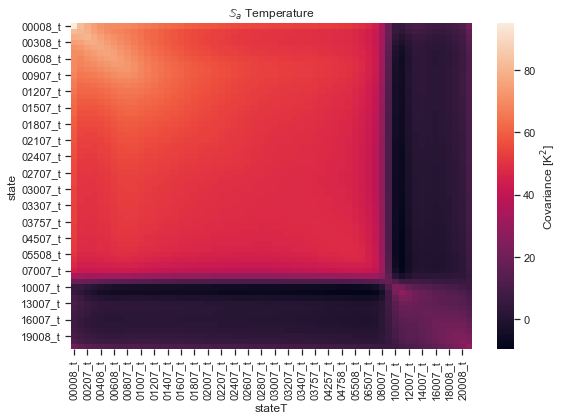

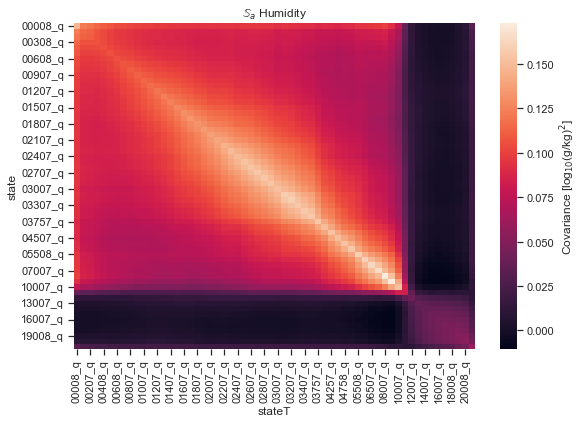

In [14]:
S_a = x_cov.sel(season='MAM').to_pandas()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Temperature')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Humidity')

As supporting information, we also need the height levels and mean pressure profiles for every season wich we also estimate form the radiosonde data set

In [15]:
height = priors['all'].height

pressure = []
for k in ['all'] + seasons:
    pressure.append(priors[k].bar_pres.mean('time'))
pressure = xr.concat(pressure, dim='season')
pressure['season'] = ['all'] + seasons
pressure = pressure.to_pandas()
pressure

height,8.000000,107.999992,207.999969,308.000000,408.000061,508.000061,608.000000,707.999878,807.999817,907.999695,...,12007.995117,13007.994141,14007.993164,15007.992188,16007.992188,17007.996094,18008.000000,19008.003906,20008.007812,22508.007812
season,,,,,,,,,,,,,,,,,,,,,
all,101411.312500,100181.101562,98893.625000,97624.539062,96374.359375,95141.609375,93925.835938,92726.820312,91542.953125,90375.398438,...,18318.185547,15714.389648,13483.758789,11570.416016,9927.844727,8520.158203,7313.539062,6281.495117,5406.569336,3732.111816
DJF,101641.226562,100320.007812,98973.242188,97648.664062,96346.171875,95064.554688,93802.890625,92560.343750,91336.171875,90128.703125,...,17581.072266,15046.706055,12882.336914,11032.179688,9446.294922,8092.613281,6931.801270,5942.553223,5098.184082,3472.734375
MAM,101837.007812,100520.359375,99206.117188,97911.289062,96636.718750,95382.406250,94146.843750,92930.109375,91730.562500,90547.296875,...,18171.298828,15596.017578,13388.307617,11491.730469,9864.220703,8466.375000,7266.686523,6237.169434,5357.356445,3669.576660
JJA,101238.234375,100016.382812,98790.179688,97582.039062,96390.351562,95214.554688,94054.148438,92907.414062,91774.906250,90655.531250,...,19332.447266,16622.179688,14297.146484,12295.776367,10573.527344,9092.315430,7819.685059,6726.113770,5785.992188,3974.533936
SON,100919.210938,99874.992188,98610.507812,97361.195312,96125.789062,94904.742188,93697.679688,92504.898438,91326.265625,90161.148438,...,18158.330078,15562.971680,13339.403320,11432.937500,9795.538086,8390.832031,7187.949219,6156.890137,5280.847168,3598.150879


Finally, we convert the profiles (which we saved before to a Pandas Object) so that can be understood by the forward operator 

In [16]:
profiles_t = profiles['temp'].to_pandas()
profiles_t.columns = ['%05i_t' % (i) for i in profiles_t.columns]
profiles_q = profiles['q'].to_pandas()
profiles_q.columns = ['%05i_q' % (i) for i in profiles_q.columns]

x_truths = pn.concat((profiles_t, profiles_q), 1)
x_truths = x_truths.reindex(sorted(x_truths.index), axis=0)
x_truths.columns.name = 'state'
x_truths.index.name = 'time'

assert np.all(np.isfinite(x_truths))
x_truths

/var/folders/cp/xzxyxf097q3b1v9h_k2spdq00000gn/T/ipykernel_54899/3360315878.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x_truths = pn.concat((profiles_t, profiles_q), 1)


state,00008_t,00107_t,00207_t,00308_t,00408_t,00508_t,00608_t,00707_t,00807_t,00907_t,...,12007_q,13007_q,14007_q,15007_q,16007_q,17007_q,18008_q,19008_q,20008_q,22508_q
time,,,,,,,,,,,,,,,,,,,,,
2004-03-16 12:00:00,248.269989,247.599991,250.889999,255.429993,258.699982,259.540009,259.109985,258.269989,257.459991,257.419983,...,-2.426702,-2.368711,-2.282595,-2.202477,-2.004690,-1.974985,-1.926023,-1.940949,-1.882235,-1.898666
2006-04-01 00:00:00,248.000000,247.239990,248.899994,251.239990,252.149994,252.819992,253.209991,253.449997,253.789993,254.509995,...,-2.158761,-2.095802,-2.306196,-2.145840,-2.194748,-2.208211,-2.195101,-2.226646,-2.278249,-2.412320
2009-01-30 18:00:00,251.729996,252.099991,254.119995,254.549988,254.549988,254.470001,254.339996,254.019989,253.879990,254.849991,...,-2.191924,-2.081939,-1.937669,-1.830115,-1.767967,-1.657959,-1.653461,-1.603367,-1.668807,-1.926275
2014-07-27 06:00:00,273.160004,271.679993,270.929993,270.350006,272.169983,273.100006,273.019989,272.919983,272.639984,272.540009,...,-2.533212,-2.516264,-2.474560,-2.435602,-2.375896,-2.302611,-2.242050,-2.217488,-2.161998,-1.946173
2018-01-08 12:00:00,248.839996,249.189987,250.159988,255.939987,257.470001,257.929993,258.100006,258.989990,259.389984,259.729980,...,-2.417694,-2.748187,-2.735237,-2.792282,-2.786179,-2.804525,-2.798916,-2.774575,-2.739619,-2.649273


# Define forward operator

Next, we define the forward operator. pyOptimalEstimation requires that the state vector $\mathbf{x}$ is the first argument of the forward operator function and the measurement vector $\mathbf{y}$ is returned. All the magic is handled by the nonScatMWRadTran library (Löhnert et al. 2004), the function `forwardRT` defined below is for converting it to the correct SI units. 

In [17]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature (or humidty) vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

See the file `lib/nonScatMWRadTran.py` for the actual forward operator code which is in detail described in Löhnert et al. (2004).

# Run reference retrieval
We start with the retrieval configuration we will call the *reference run* in the following

We use the standard frequencies in GHz of an HATPRO microwave radiometer (Rose et al 2005)

In [18]:
frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]

We need names for our $\mathbf{y}$ and $\mathbf{x}$ variables to avoid any confusion. For $\mathbf{y}$, we select the frequencies, for $\mathbf{x}$ we use a string containing the height in meters and the variable names defined above

In [19]:
y_vars = np.array(frequencies)
x_vars = x_mean.state.values
print('y_vars:\n', y_vars)
print('x_vars:\n', x_vars)

y_vars:
 [22.24 23.04 23.84 25.44 26.24 27.84 31.4  51.26 52.28 53.86 54.94 56.66
 57.3  58.  ]
x_vars:
 ['00008_q' '00008_t' '00107_q' '00107_t' '00207_q' '00207_t' '00308_q'
 '00308_t' '00408_q' '00408_t' '00508_q' '00508_t' '00608_q' '00608_t'
 '00707_q' '00707_t' '00807_q' '00807_t' '00907_q' '00907_t' '01007_q'
 '01007_t' '01107_q' '01107_t' '01207_q' '01207_t' '01307_q' '01307_t'
 '01407_q' '01407_t' '01507_q' '01507_t' '01607_q' '01607_t' '01707_q'
 '01707_t' '01807_q' '01807_t' '01907_q' '01907_t' '02007_q' '02007_t'
 '02107_q' '02107_t' '02207_q' '02207_t' '02307_q' '02307_t' '02407_q'
 '02407_t' '02507_q' '02507_t' '02607_q' '02607_t' '02707_q' '02707_t'
 '02807_q' '02807_t' '02907_q' '02907_t' '03007_q' '03007_t' '03107_q'
 '03107_t' '03207_q' '03207_t' '03307_q' '03307_t' '03407_q' '03407_t'
 '03507_q' '03507_t' '03757_q' '03757_t' '04007_q' '04007_t' '04257_q'
 '04257_t' '04507_q' '04507_t' '04758_q' '04758_t' '05008_q' '05008_t'
 '05508_q' '05508_t' '06008_q' '06008_t' '0

## Prepare retrieval

For this example we use the atmospheric profile at Barrow at 2006-04-01T00:00:00 which we call $\mathbf{x}_{truth}$ in the following

In [20]:
season = 'MAM'  #Spring: March April May
profile = np.datetime64('2006-04-01T00:00:00')
x_truth = x_truths.loc[profile]
x_truth

state
00008_t    248.000000
00107_t    247.239990
00207_t    248.899994
00308_t    251.239990
00408_t    252.149994
              ...    
17007_q     -2.208211
18008_q     -2.195101
19008_q     -2.226646
20008_q     -2.278249
22508_q     -2.412320
Name: 2006-04-01 00:00:00, Length: 120, dtype: float32

The measurement uncertainty is expressed as a covariance matrix (**S**$_y$) which have been determined by continuously measuring the brightness temperatures of a black body with a known temperature.  For now, we assume that covariances between the channels can be neglected, i.e. **S**$_y$ is a diagonal matrix. Describing measurement uncertainties (and the prior) with a covariance matrix implies that the variability can be described with a normal distribution.



In [21]:
y_noise = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)


**S**$_y$ is visualized with:

Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$')

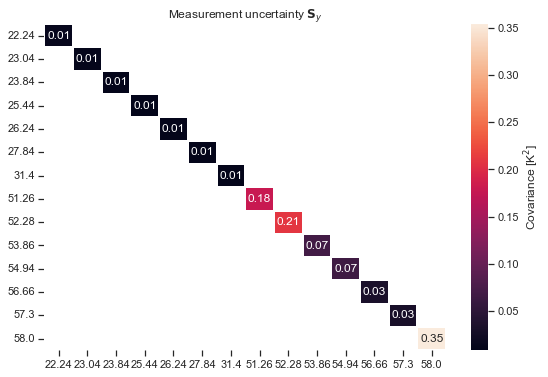

In [22]:

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    S_y.where(S_y > 0), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$')


The prior **S**$_a$ is obtained from the mean and covariance matrix provided in the netCDF file loaded above. 

In [23]:
x_a = x_mean.sel(season='MAM').to_pandas()[x_vars]
S_a = x_cov.sel(season='MAM').to_pandas().loc[x_vars, x_vars]

It is crucial that **S**$_a$ and **S**$_y$ can be inverted. When using different units in $\mathbf{x}$ and/or $\mathbf{y}$ and mixing very small and large values, the inversion might fail for numerical reasons. In this case we recommend to experiment with different units.

Note: Numpy's `np.linalg.inv` does not always catch singular matrices as shown below:

In [24]:
singularMatrix = np.array([[1,0,0], [1,0,1e-50], [1,1e-50,0]])
np.linalg.inv(singularMatrix)

array([[ 1.e+00,  0.e+00,  0.e+00],
       [-1.e+50,  0.e+00,  1.e+50],
       [-1.e+50,  1.e+50,  0.e+00]])

Therefore, it is recommended to use pyOptimalEstimation's `pyOE.invertMatrix` function which checks for matrix singularity. (The `try` and `except` is only to make sure the Notebook does not stop after the error is raised)

In [25]:
try:
    pyOE.invertMatrix(singularMatrix)
except Exception as err:
    traceback.print_tb(err.__traceback__)

  File "/var/folders/cp/xzxyxf097q3b1v9h_k2spdq00000gn/T/ipykernel_54899/384370707.py", line 2, in <module>
    pyOE.invertMatrix(singularMatrix)
  File "/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/pyOptimalEstimation/pyOEcore.py", line 1266, in invertMatrix
    raise ValueError("Found singular matrix", UserWarning)


Based on the true profile, we create a synthetic observation. Auxiliary data which needs to be passed on to the `forwardRT` function is stored in the `forwardKwArgs` dictionary. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [26]:
forwardKwArgs = dict(
    pressure=pressure.loc['MAM'].values,
    zenithAngle=0,
    frequencies=frequencies
)

y_obs = forwardRT(x_truth, **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

The resulting brightness temperatures are storted in  $\mathbf{y}_{obs}$ (`y_obs`)

In [27]:
y_obs

22.24     14.466894
23.04     13.997798
23.84     12.696146
25.44     11.040978
26.24     10.734442
27.84     10.689742
31.40     11.942638
51.26    105.147974
52.28    143.741944
53.86    230.379525
54.94    251.512077
56.66    250.604009
57.30    250.073282
58.00    249.693972
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe_ref` 

In [28]:
oe_ref = pyOE.optimalEstimation(
    x_vars, # state variable names
    x_a,  # a priori
    S_a, # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs, # observations
    S_y, # observation uncertainty
    forwardRT, # forward Operator
    forwardKwArgs=forwardKwArgs, # additonal function arguments
    x_truth=x_truth, # true profile
)

Note that $\mathbf{x}_{truth}$ is only added to the `pyOE` object for convenience, it is not used to find a solution.

## Run retrieval
We are finally ready to run the retrieval. 

In [29]:
oe_ref.doRetrieval()

4.45 s, iteration 1, degrees of freedom: 4.70 of 120, not converged (x-space):  938.423
5.29 s, iteration 2, degrees of freedom: 4.67 of 120, not converged (x-space):  23.517
6.10 s, iteration 3, degrees of freedom: 4.67 of 120, converged (x-space):  0.118
6.89 s, iteration 4, degrees of freedom: 4.67 of 120, done.  0.000


True

As can be seen from the output, convergence is reached at the third iteration. After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with (only the first 10 elements are shown)

In [30]:
print(oe_ref.x_op[:10])
print(oe_ref.S_op[:10])

00008_q     -0.396555
00008_t    249.191496
00107_q     -0.376150
00107_t    248.462184
00207_q     -0.360388
00207_t    248.236036
00308_q     -0.340507
00308_t    249.167029
00408_q     -0.327820
00408_t    250.381067
dtype: float64
          00008_q   00008_t   00107_q   00107_t   00207_q   00207_t   00308_q  \
00008_q  0.015584  0.372022  0.002714 -0.000578  0.001970 -0.096688  0.002094   
00008_t  0.372022  9.474031  0.050433 -0.040050  0.034357 -2.414092  0.039127   
00107_q  0.002714  0.050433  0.005088  0.049410  0.004548 -0.001782  0.003777   
00107_t -0.000578 -0.040050  0.049410  1.512931  0.028072  0.400961  0.013133   
00207_q  0.001970  0.034357  0.004548  0.028072  0.006716  0.006762  0.006072   
00207_t -0.096688 -2.414092 -0.001782  0.400961  0.006762  1.558333 -0.009706   
00308_q  0.002094  0.039127  0.003777  0.013133  0.006072 -0.009706  0.009475   
00308_t -0.134082 -3.364744 -0.045699 -0.742802 -0.024695  0.970029 -0.012464   
00408_q  0.002062  0.040396  0.00318

pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are not mixed up.

For convenience, the one sigma uncertainties derived from **S**$_{op}$ are also available

In [31]:
print(oe_ref.x_op_err[:10])

00008_q    0.124836
00008_t    3.077991
00107_q    0.071329
00107_t    1.230013
00207_q    0.081954
00207_t    1.248332
00308_q    0.097337
00308_t    1.595339
00408_q    0.109544
00408_t    1.809465
dtype: float64




An important output is the degrees of freedom for signal $d$ which describe the number of independent information pieces obtained from the measurement by the retrieval. The final $d$ can be  accessed as a total value, and per element of $\mathrm{x}$

In [32]:
print('total', oe_ref.dgf)
print(oe_ref.dgf_x[:10])

total 4.665610745536389
00008_q    0.002264
00008_t    0.236773
00107_q    0.007301
00107_t    0.332635
00207_q    0.009668
00207_t    0.221344
00308_q    0.013774
00308_t    0.151885
00408_q    0.018009
00408_t    0.118619
dtype: float64


## Analyze the results
After running the retrieval, the `oe_ref` object contains also the retrieval result. In addition, `pyOptimalEstimation` provides a tool set of functions to asses model quality as introduced below. We encourage the reader to look at the documentation with `help(oe_ref)` or `oe_ref?` even though we will present the most important features in the following.

In [33]:
help(oe_ref)

Help on optimalEstimation in module pyOptimalEstimation.pyOEcore object:

class optimalEstimation(builtins.object)
 |  optimalEstimation(x_vars, x_a, S_a, y_vars, y_obs, S_y, forward, x_truth=None, b_vars=[], b_p=[], S_b=[[]], x_lowerLimit={}, x_upperLimit={}, useFactorInJac=False, gammaFactor=None, disturbance=0.1, convergenceFactor=10, convergenceTest='x', forwardKwArgs={})
 |  
 |  The core optimalEstimation class, which contains all required parameters.
 |  See [1]_ for an extensive introduction into Optimal Estimation theory.
 |  
 |  Parameters
 |  ----------
 |  x_vars : list of str
 |      names of the elements of state vector x.
 |  x_a : pd.Series or list or np.ndarray
 |      prior information of state x.
 |  S_a : pd.DataFrame or list or np.ndarray
 |      covariance matrix of state x.
 |  y_vars : list of str
 |      names of the elements of state vector x
 |  y_obs : pd.Series or list or np.ndarray
 |      observed measurement vector y.
 |  S_y : pd.DataFrame or list or n

### Iterations
The function `plotIterations` visualizes the itrations of `pyOptimalEstimation` to the estimated result on the x axis: Iteration 0 is the first guess (in our case the prior), the solid line at iteration 3 is where the retrieval converges. $\mathbf{x}_{truth}$ (first panel) and $\mathbf{y}_{ob}$ (second panel) are on the very right. The degrees of freedom and the convergence criterion (see Sec. 5.6.2 of Rodgers, 2000) are displayed in the third and fourth panel, respectively.

/Users/mmaahn/miniconda3/envs/py38/lib/python3.8/site-packages/pyOptimalEstimation/pyOEcore.py:1120: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)


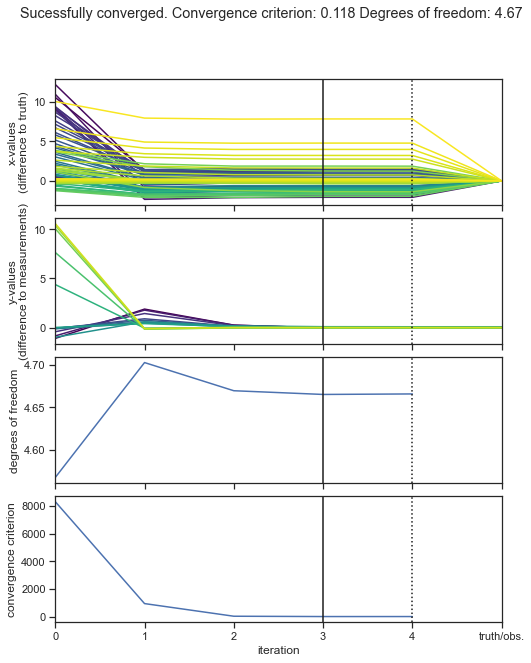

In [34]:
fig = oe_ref.plotIterations(legend=False, mode='difference')

### Solution
The optimal solution $\mathbf{x}_{optimal}$ can be accessed with 

In [35]:
oe_ref.x_op

00008_q     -0.396555
00008_t    249.191496
00107_q     -0.376150
00107_t    248.462184
00207_q     -0.360388
              ...    
19008_t    221.712377
20008_q     -2.169208
20008_t    221.308620
22508_q     -2.198133
22508_t    220.638699
Length: 120, dtype: float64

and the according aposteriori correlation **S**$_{optimal}$ is accessible as `oe_ref.S_op ` which we plot with

Text(0.5, 1.0, '$\\mathbf{S}_{op}$ Humidity')

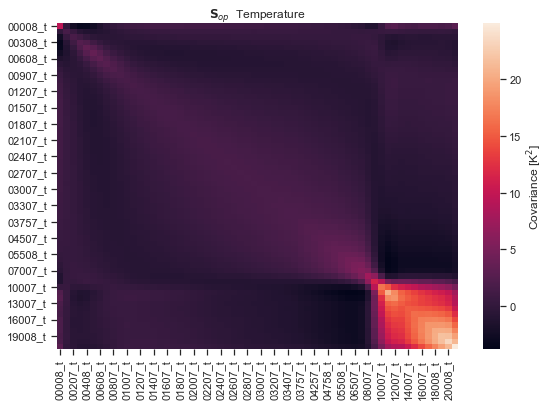

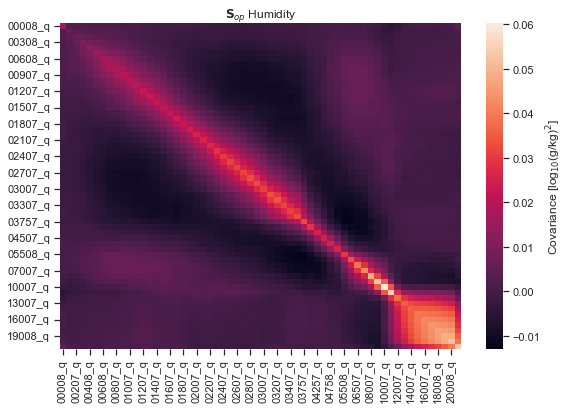

In [36]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbf{S}_{op}$  Temperature')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbf{S}_{op}$ Humidity')

The square of the diagonal of are the uncertainties of the optimal solution (1 $\sigma$ range) which can be also found in 

In [37]:
oe_ref.x_op_err

00008_q    0.124836
00008_t    3.077991
00107_q    0.071329
00107_t    1.230013
00207_q    0.081954
             ...   
19008_t    4.659842
20008_q    0.227658
20008_t    4.825680
22508_q    0.230522
22508_t    4.996268
Length: 120, dtype: float64

Using a specific helper routine from `lib/supporting_routines.py` , we plot the prior and the result as vertical profiles of temperature and humidity.

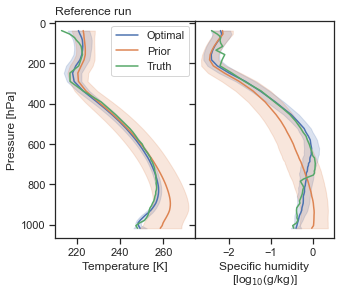

In [38]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.loc[season] / 100,
    hlabel='Pressure [hPa]',
    title='Reference run')

### Root mean square error
`supporting_routines` also contains a helper routine to split $\mathbf{x}$ into temperature and humidity. This allows us to e.g. estimate the root mean square errors (RMS) for $\mathbf{x}$ (and $\mathbf{y}$)

In [39]:
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

RMS X Temperature: 1.79078 [K]
RMS X Humidity: 0.153607 [log$_{10}$(g/kg)]
RMS Y 0.0424138 [K]


Note that we can only estimate the RMS for $\mathbf{x}$, because we used synthetic observations and know $\mathbf{x}_{truth}$

### Statistical tests

We recommend applying various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior **S**$_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior **S**$_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior **S**$_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 


In [40]:
chiSquareTest = oe_ref.chiSquareTest(significance=0.05)

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       


The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [41]:
print('\nTests passed:\n' ,chiSquareTest[0])


Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


### Linearity tests
Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

In [42]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_ref.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  True


In case $\mathbf{x}_{truth}$ is  unknown, error patterns of **S** can be used instead (`linearity`). Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. Note that this is less accurate than when $\mathbf{x}_{truth}$ is known.

# Run modified retrieval
In the following, we modify the retrieval in various ways and asses the impact on retrieval quality. The reader is strongly encouraged to play around with the various parameters. 

## Modifying the prior: Ignoring non-diagonal elements of **S**$_a$

The prior data set is crucial for selecting the most likely atmospheric state for a given measurement. Here, we investigate what happens when only diagonal values in **S**$_a$ are considered, i.e. correlations are ignored.

In [41]:

S_a_diag = np.diag(np.diag(S_a))

The retrieval needs six iterations to converge which also indicates the larger instability of the retrieval

In [46]:
# oe_test1 = pyOE.optimalEstimation(
#     x_vars,
#     x_a,
#     S_a,  <- change to S_a_diag!!!
#     y_vars,
#     y_obs,
#     S_y,
#     forwardRT,
#     x_truth=x_truth,
#     forwardKwArgs=forwardKwArgs,
# )
# oe_test1.doRetrieval()

## Modify prior: Using summer instead of spring data 


Here we investigate what happens with the retrieval if an unsuited prior is selected. For this we swap the prior $\mathbf{x}_a$ and **S**$_a$ with data based on summer instead of spring observations

In [43]:
x_a_wrong = x_mean.sel(season='JJA').to_pandas()
S_a_wrong = x_cov.sel(season='JJA').to_pandas()
forwardKwArgs_wrong = dict(
    pressure=pressure.loc['JJA'].values,
    zenithAngle=0,
    frequencies=frequencies
)

In [45]:
# oe_test2 = pyOE.optimalEstimation(
#     x_vars,
#     x_a, <- change to x_a_wrong!!!
#     S_a, <- change to S_a_diag!!!
#     y_vars,
#     y_obs,
#     S_y,
#     forwardRT,
#     x_truth=x_truth,
#     forwardKwArgs=forwardKwArgs, <- change to forwardKwArgs_wrong!!!
# )
# oe_test2.doRetrieval()